Graph Attention Model Training and Testing

In [2]:
import numpy as np
import torch
from torch.nn import MSELoss
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error

def train_gat(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):

    # Create dictionary to save all results (used for plots)
    results_dict = {
        'train_loss': [],
        'train_mae': [],
        'val_loss': [],
        'val_mae': [],
        'train_preds': [],
        'train_targets': [],
        'val_preds': [],
        'val_targets': [],
    }

    # Start model, with Adam optimizer and MSE loss
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    best_val_mae = float('inf')
    best_val_rmse = float('inf')
    best_model_state = None

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []

        train_preds = []
        train_targets = []

        # Train loop
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_fn(out, batch.y.float())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_preds.extend(out.detach().cpu().numpy())
            train_targets.extend(batch.y.cpu().numpy())

        train_mae = mean_absolute_error(train_targets, train_preds)

        model.eval()

        val_preds = []
        val_targets = []

        # Validation loop
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                val_preds.extend(out.cpu().numpy())
                val_targets.extend(batch.y.cpu().numpy())

        # Rest of function stores information of model
        val_mae = mean_absolute_error(val_targets, val_preds)
        val_rmse = np.sqrt(np.mean([(pred - target)**2 for pred, target in zip(val_preds, val_targets)]))

        print(f"Epoch {epoch:03d}: Train Loss = {sum(train_losses)/len(train_losses):.4f}, Val MAE = {val_mae:.2f}, Val RMSE = {val_rmse:.2f}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_val_rmse = val_rmse
            best_model_state = model.state_dict()

            results_dict['train_preds'] = train_preds
            results_dict['train_targets'] = train_targets
            results_dict['val_preds'] = val_preds
            results_dict['val_targets'] = val_targets

        results_dict['train_loss'].append(sum(train_losses)/len(train_losses))
        results_dict['train_mae'].append(train_mae)

        val_losses = [(pred - target)**2 for pred, target in zip(val_preds, val_targets)]
        val_loss_epoch = sum(val_losses) / len(val_losses)
        results_dict['val_loss'].append(val_loss_epoch)
        results_dict['val_mae'].append(val_mae)
        

    return best_model_state, best_val_mae, best_val_rmse, results_dict


In [3]:
from graph_attention_model import GATRegressor
from create_dataset import BrainGraphDataset

from sklearn.model_selection import KFold
from torch_geometric.loader import DataLoader
import pickle

graph_list = torch.load("brain_graph_dataset.pt", weights_only=False)
dataset = BrainGraphDataset(graph_list)

# Set up cross validation for data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, val_idx in kf.split(dataset):
    train_subset = [dataset[i] for i in train_idx]
    val_subset = [dataset[i] for i in val_idx]

    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=8)

    folds.append((train_loader, val_loader))


## Train and validate model for all folds
all_fold_maes = []
all_fold_rmses = []
all_results = {}

for fold, (train_loader, val_loader) in enumerate(folds):
    print(f"\nFold {fold+1} --------------------------")

    # Can change hyperparameters here
    model = GATRegressor(in_channels=3, hidden_channels=64, heads=4)
    best_state, best_mae, best_rmse, results = train_gat(model, train_loader, val_loader, lr=1e-5, epochs=100)

    # Evaluate success of model
    print(f"Fold {fold+1} Best MAE: {best_mae:.2f}, Best RMSE: {best_rmse:.2f}")
    all_fold_maes.append(best_mae)
    all_fold_rmses.append(best_rmse)
    all_results[fold] = results

print("\nCross-validation summary:")
print(f"MAE per fold: {all_fold_maes}")
print(f"Mean MAE: {sum(all_fold_maes)/len(all_fold_maes):.2f}")

# Save results for plotting
with open("training_results.pkl", "wb") as f:
    pickle.dump(all_results, f)


Fold 1 --------------------------
Epoch 001: Train Loss = 11247.3159, Val MAE = 27.58, Val RMSE = 28.10
Epoch 002: Train Loss = 159.3836, Val MAE = 4.74, Val RMSE = 5.92
Epoch 003: Train Loss = 36.0947, Val MAE = 4.72, Val RMSE = 5.86
Epoch 004: Train Loss = 35.6014, Val MAE = 4.71, Val RMSE = 5.79
Epoch 005: Train Loss = 34.8027, Val MAE = 4.65, Val RMSE = 5.78
Epoch 006: Train Loss = 34.2874, Val MAE = 4.61, Val RMSE = 5.68
Epoch 007: Train Loss = 33.0045, Val MAE = 4.56, Val RMSE = 5.62
Epoch 008: Train Loss = 32.0273, Val MAE = 4.47, Val RMSE = 5.48
Epoch 009: Train Loss = 30.6020, Val MAE = 4.45, Val RMSE = 5.44
Epoch 010: Train Loss = 29.7620, Val MAE = 4.39, Val RMSE = 5.38
Epoch 011: Train Loss = 28.6145, Val MAE = 4.36, Val RMSE = 5.32
Epoch 012: Train Loss = 27.3955, Val MAE = 4.31, Val RMSE = 5.22
Epoch 013: Train Loss = 26.1808, Val MAE = 4.28, Val RMSE = 5.17
Epoch 014: Train Loss = 25.2306, Val MAE = 4.24, Val RMSE = 5.13
Epoch 015: Train Loss = 24.7376, Val MAE = 4.15, 

In [7]:
print("\nCross-validation summary:")
print(f"MAE per fold: {all_fold_maes}")
print(f"RMSE per fold: {all_fold_rmses}")
print(f"Mean MAE: {sum(all_fold_maes)/len(all_fold_maes):.2f}")
print(f"Mean MAE: {sum(all_fold_rmses)/len(all_fold_rmses):.2f}")


Cross-validation summary:
MAE per fold: [3.6012852986653647, 3.6610326543100564, 3.487845111900652, 3.3003832857373734, 3.756514052270164]
RMSE per fold: [np.float32(4.3034124), np.float32(4.519317), np.float32(4.308029), np.float32(4.1473155), np.float32(4.5436225)]
Mean MAE: 3.56
Mean MAE: 4.36


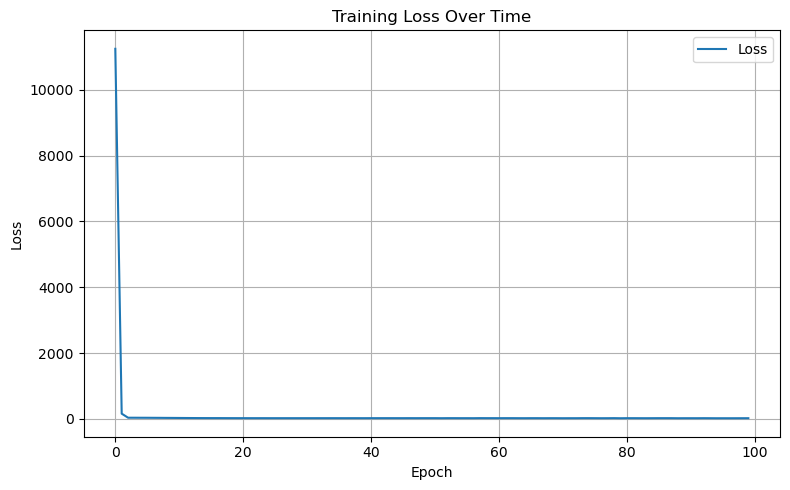

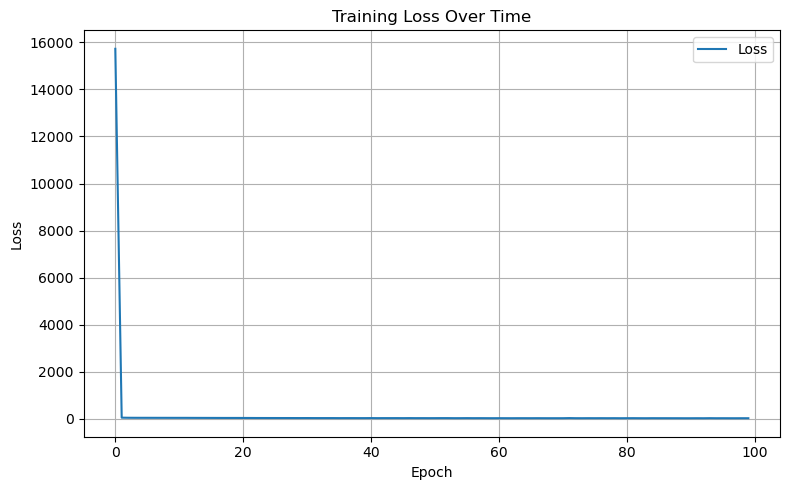

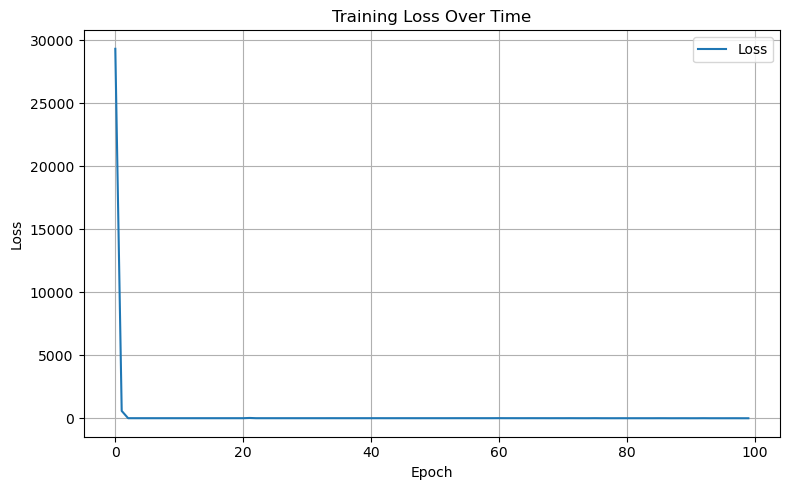

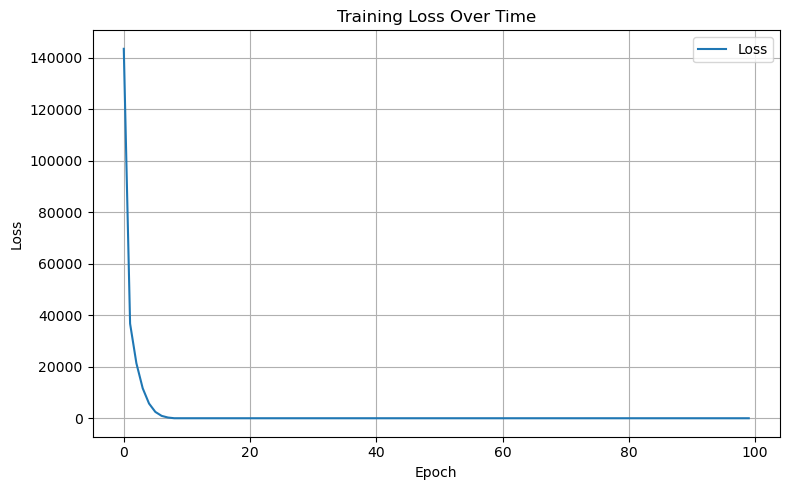

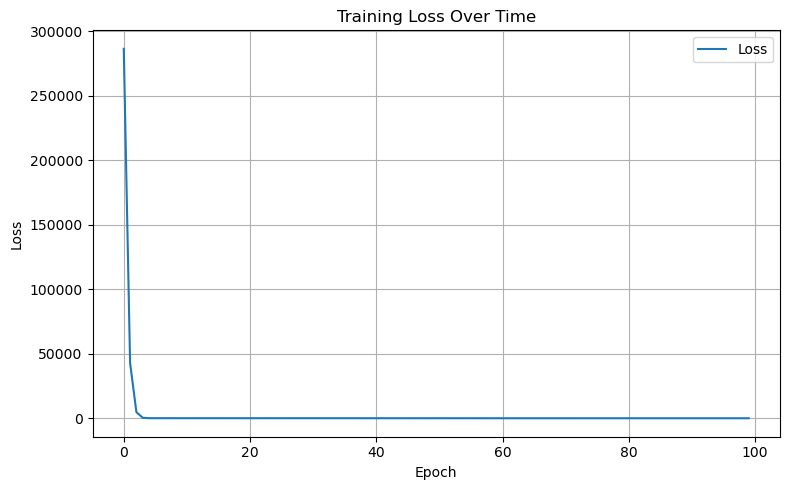

In [5]:
import sys
sys.path.append("/projectnb/ec523/projects/proj_GS_LQ_EPB/helper_functions")

from ml_plot import MLPlot

import pickle

with open("training_results.pkl", "rb") as f:
    all_results = pickle.load(f)

mlplot = MLPlot()
for fold, results in all_results.items():
    mlplot.plot_loss(results['train_loss'])